# Business Understanding

## Wie (de opdrachtgever)? 

Appbakkers (Corné & Guido) is een bedrijf die (mobiele) applicaties ontwikkeld.  

## Wat (de opdracht)? 

Bij opname van een patiënt wordt er een elektrocardiogram (ECG) gemaakt. Hierbij worden alle elektrische impulsen in het hart geregistreerd, waardoor kan worden afgeleid welke gebieden van het hart naar behoren functioneren.  

Het maken van een ECG kost tijd en geld, en het zou mooi zijn om het maken van een ECG te voorkomen voor mensen die uiteindelijk niets mankeren. Dit voorkomen doen we met de risicoformulieren die de patient van te voren invult. Hierbij is ook van belang dat we zoveel mogelijk de false negative uitkomsten zo laag houden, omdat we mensen die uiteindelijk wel een CVD hebben, niet willen afwijzen.

## Wanneer (tijdsframe)? 

Deze opdracht voeren we uit vanaf 13 april ’22. Op deze dag hebben we de kennismaking gehad met onze opdrachtgever. Hierin hebben we de opdracht besproken en een aantal afspraken gemaakt. De einddatum van de opdracht zal zijn op 3 juni ’22. 

## Waarom (doel)? 

Het doel is om een model te hebben die kan voorspellen of een patient een grote kans heeft op een CVD, waarbij  

Als het model gemaakt is, wordt het gebruikt om te voorspellen of het nuttig is om een ECG te maken bij een patient.  

## Wat (wat gaan we gebruiken)? 

Door middel van Jupyter notebooks gaan wij het model ontwikkelen.  
ECG viewer om ECG´s bestanden door te lezen. 

# Data Understanding

Wij hebben 2 publieke datasets gekregen om mee bezig te gaan. Deze zijn "cardio_train.csv" en "riskchartsampledata.xlsx". Wij gaan gebruik maken van "cardio_train.csv", omdat deze het meeste lijkt op de data die we komende week ontvangen. Hieronder is te lezen wat de kolommen in deze dataset betekenen.

### "cardio_train.csv"

* id          
    De id van de rij, **integer** <br/>
* age         
    De leeftijd van de patient in dagen, **integer** <br/>
* gender      
    Het geslacht van de patient, waarbij 1 een man is en 2 een vrouw, **category** <br/>
* height      
    De lengte van de patient, gegeven in centimeters, **integer** <br/>
* weight      
    Het gewicht van de patient, gegeven in kilogram, **float** <br/>
* ap_hi       
    De bovendruk van de patient, **integer**  <br/>
* ap_lo       
    De onderdruk van de patient, **integer**  <br/>
* cholesterol <br/>
    Hoe veel cholesterol de patient heeft, **category**  <br/>
* gluc        
    Hoe veel glucoses de patient heeft, **category**  <br/>
* smoke       
    Of de patient rookt, **boolean** <br/>
* alco        
    Of de patient alcohol drinkt, **boolean** <br/>
* active      
    Of de patient actief is in het dagelijks leven, **boolean** <br/>
* cardio      
    Of de patient een cardiovasculaire ziekte heeft, **boolean** <br/>

In [50]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import pandas_profiling as pp

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV # this will do cross validation
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample # downsample the dataset
from sklearn.preprocessing import scale # scale and center data
from sklearn.svm import SVC, LinearSVC # this will make a support vector machine for classification
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

%matplotlib inline

In [23]:
cardio_train = pd.read_csv("Data/cardio_train.csv", delimiter=';')

In [24]:
#report1 = pp.ProfileReport(cardio_train, progress_bar=False)
#report1.to_file('report1.html')


[Report van cardio_train](report1.html)

## Gender in cardio_train

In [25]:
cardio_train[['gender','height']].groupby('gender').agg(np.mean)


,height
gender,
1,161.355612
2,169.947895


De personen met 2 als gender zijn gemiddeld langer, dus is de 2 een man en 1 een vrouw.

### Data Relationships

<AxesSubplot:ylabel='count'>

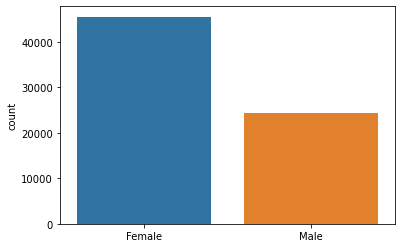

In [26]:
sns.countplot(x=pd.Series(['Male' if x == 2 else 'Female' for x in cardio_train['gender']]).astype('category'))

Text(0.5, 1.0, 'Age Composition based on gender')

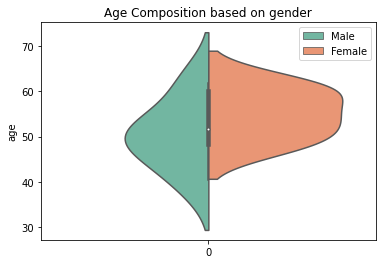

In [27]:
ax = sns.violinplot(x=pd.Series([0 for x in cardio_train]), 
                    y=cardio_train["age"]/365, 
                    hue=pd.Series(['Male' if x == 2 else 'Female' for x in cardio_train['gender']]).astype('category'),
                    data=cardio_train, palette="Set2", split=True,
                    scale="count",
                    hue_order=['Male','Female'])
ax.set_title('Age Composition based on gender')

Hieruit is te leiden dat de mannen een groter leeftijdsbereik hebben dan de vrouwen.

Text(0.5, 1.0, 'Composition of cardiovascular disease in gender')

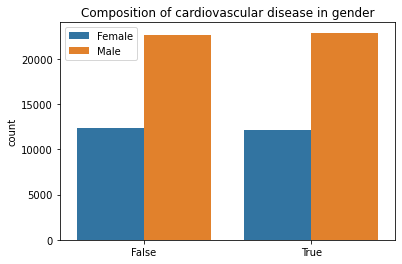

In [28]:
ax = sns.countplot(hue=pd.Series(['Male' if x == 1 else 'Female' for x in cardio_train['gender']]).astype('category'),
                   x=pd.Series([True if x == 0 else False for x in cardio_train['cardio']]))
ax.set_title('Composition of cardiovascular disease in gender')

Hieruit is te leiden dat de data gelijk is verdeeld in de kolom cardio. 50% had uiteindelijk een cvd, en 50% niet.

# Data Preparation

In [29]:
#cardio_train.astype({'gender':'category','cholesterol':'category','gluc':'category','smoke':'bool','alco':'bool','active':'bool','cardio':'bool'}, copy=False)

## Feature Engineering

In [30]:
#if (1 in cardio_train['gender'].unique()):
#    cardio_train['gender'] = ['male' if x is 2 else 'female' for x in cardio_train['gender']]
#cardio_train.astype('category',copy=False)


#cardio_train['age_category'] = pd.cut(cardio_train['age_in_years'], range(5,105,10))
#age_cat = [str(x.left) + '-' + str(x.right-1) for x in cardio_train['age_category']]
#cardio_train['age_category'] = age_cat
#cardio_train['age_category'].astype('category',copy=False)

In [31]:
cardio_train['age'] = (cardio_train['age']/365).apply(lambda x: int(x))


cardio_train['bmi'] = cardio_train['weight'] / (cardio_train['height']/100)**2 

cardio_train['ap_difference'] = cardio_train['ap_hi'] - cardio_train['ap_lo']


## Outlier filtering

In [32]:
cardio_train = cardio_train[~(cardio_train['bmi']>60)]


high_ap_filter = ((cardio_train["ap_hi"]>220) | (cardio_train["ap_lo"]>180))
cardio_train = cardio_train[~high_ap_filter]

low_ap_filter = ((cardio_train["ap_hi"] < 40) | (cardio_train["ap_lo"] < 40))
cardio_train = cardio_train[~low_ap_filter]

## Bovendruk kan niet lager zijn dan onderdruk

In [33]:
# ap_hi kan niet lager zijn dan ap_lo
cardio_train = cardio_train[:][cardio_train['ap_hi'] > cardio_train['ap_lo']]
cardio_train.shape


(68602, 15)

## Drop Duplicates

### How many?

In [34]:
cardio_train.duplicated().sum()

0

In [35]:
cardio_train.drop_duplicates(inplace=True)
cardio_train.shape

(68602, 15)

## Make Dummies of categories with more than 2 possibilities


Stel dat je een een kolom hebt met 3 categorien:

1. Married
2. Single
3. Other

Als je deze kolom met nummers behandelt als continuous data dan denkt het algoritme dat 2 dichter bij 3 staat dan 1 bij 3 terwijl dit niet het geval is. Je wilt ze dus als categorical data behandelen.

zie:

ColumnTransformer()

get_dummies()

In [36]:
cardio_train_with_dummies = pd.get_dummies(cardio_train, columns=['cholesterol','gluc'])

## Splitting

In [37]:
def CopyAndNormalize(train, test, columnNames):
    norm = train.copy()
    normtest = test.copy()
    norm['gender'] = norm['gender']-1
    normtest['gender'] = normtest['gender']-1
    for col in columnNames:
        normtest[col] = (normtest[col]-norm[col].min()) / (norm[col].max()-norm[col].min())
        norm[col] = (norm[col]-norm[col].min()) / (norm[col].max()-norm[col].min())
    return (norm, normtest)

def GetValidationSet(data_train, label_train):
    output = train_data.copy()
    return train_test_split(data_train, label_train, test_size=0.5, random_state=42)

def FilterDataFrame(df, columns):
    for column in columns:
        df = df.loc[:, df.columns != column]
    return df

cardio_train_with_dummies

,id,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,bmi,ap_difference,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,0,50,2,168,62.0,110,80,0,0,1,0,21.967120,30,1,0,0,1,0,0
1,1,55,1,156,85.0,140,90,0,0,1,1,34.927679,50,0,0,1,1,0,0
2,2,51,1,165,64.0,130,70,0,0,0,1,23.507805,60,0,0,1,1,0,0
3,3,48,2,169,82.0,150,100,0,0,1,1,28.710479,50,1,0,0,1,0,0
4,4,47,1,156,56.0,100,60,0,0,0,0,23.011177,40,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52,2,168,76.0,120,80,1,0,1,0,26.927438,40,1,0,0,1,0,0
69996,99995,61,1,158,126.0,140,90,0,0,1,1,50.472681,50,0,1,0,0,1,0
69997,99996,52,2,183,105.0,180,90,0,1,0,1,31.353579,90,0,0,1,1,0,0
69998,99998,61,1,163,72.0,135,80,0,0,0,1,27.099251,55,1,0,0,0,1,0


In [38]:
#Get labels
labels = cardio_train['cardio']
cols = ['age','ap_hi','ap_lo','bmi','ap_difference','height','weight']
cardio_train_norm, _ = CopyAndNormalize(cardio_train,cardio_train,cols)
cardio_train = FilterDataFrame(cardio_train, columns = ['cardio'])
cardio_train_with_dummies = FilterDataFrame(cardio_train_with_dummies, columns = ['cardio'])

#Split to train and test
data_train, data_test, label_train, label_test = train_test_split(cardio_train, labels, random_state=42, test_size=0.3, stratify=cardio_train['gender'])

#Normalize the data
cols = ['age','ap_hi','ap_lo','cholesterol','bmi','ap_difference','gluc']
normalized_train, normalized_test = CopyAndNormalize(data_train,data_test,cols)

#Split to train and test
data_train_dum, data_test_dum = train_test_split(cardio_train_with_dummies, random_state=42, test_size=0.3, stratify=cardio_train['gender'])

#Normalize the data with dummies
cols = ['age','ap_hi','ap_lo','bmi','ap_difference','height','weight']
normalized_train_dum, normalized_test_dum = CopyAndNormalize(data_train_dum,data_test_dum,cols)




### Remove columns for the models (per model)

In [39]:
# Use this as a filter for which columns you dont want in your model
columns_to_remove = ['id','height','weight','gluc']

NB_data_train = FilterDataFrame(data_train, columns = columns_to_remove)
NB_data_test = FilterDataFrame(data_test, columns = columns_to_remove)

In [40]:
columns_to_remove = ['id','height','weight']

LSVC_data_train = FilterDataFrame(data_train, columns = columns_to_remove)
LSVC_data_test = FilterDataFrame(data_test, columns = columns_to_remove)

In [41]:
columns_to_remove = ['id','cardio']

SVM_data_train = FilterDataFrame(data_train_dum, columns = columns_to_remove)
SVM_data_test = FilterDataFrame(data_test_dum, columns = columns_to_remove)

In [42]:
columns_to_remove = ['id','bmi','ap_difference']

DTC_data_train = FilterDataFrame(data_train, columns = columns_to_remove)
DTC_data_test = FilterDataFrame(data_test, columns = columns_to_remove)

In [43]:
columns_to_remove = ['id']

LR_data_train = FilterDataFrame(data_train, columns = columns_to_remove)
LR_data_test = FilterDataFrame(data_test, columns = columns_to_remove)

In [44]:
columns_to_remove = ['id','height','weight']
NN_normalized_test = FilterDataFrame(normalized_test, columns = columns_to_remove)
NN_normalized_train = FilterDataFrame(normalized_train, columns = columns_to_remove)
NN_val_data_train, NN_data_train, NN_val_lab_train, NN_lab_train = train_test_split(NN_normalized_train, label_train, test_size=0.5, random_state=42)
NN_normalized_test

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,ap_difference
23417,0.514286,1,0.5000,0.428571,0.0,0.0,0,0,1,0.511542,0.269231
69617,0.742857,0,0.3125,0.285714,0.0,0.0,0,0,1,0.373017,0.192308
54763,0.857143,0,0.6875,0.571429,1.0,0.0,0,0,1,0.830314,0.346154
52609,0.800000,0,0.3750,0.214286,0.0,0.0,0,0,1,0.360941,0.346154
5748,0.514286,1,0.3750,0.285714,0.0,0.0,1,1,1,0.383598,0.269231
...,...,...,...,...,...,...,...,...,...,...,...
56044,0.742857,0,0.3750,0.214286,1.0,0.0,0,1,1,0.423160,0.346154
46974,0.885714,0,0.3750,0.285714,0.0,0.0,0,0,1,0.374734,0.269231
25504,0.685714,0,0.4375,0.285714,0.5,0.0,0,0,1,0.289099,0.346154
17726,0.457143,0,0.3750,0.285714,0.0,0.0,0,0,1,0.498315,0.269231


In [45]:
columns_to_remove = ['id']

KNC_data_train = FilterDataFrame(normalized_train, columns = columns_to_remove)
KNC_data_test = FilterDataFrame(normalized_test, columns = columns_to_remove)

# Modeling

## Clustering

<AxesSubplot:title={'center':'Elleboog Grafiek'}, xlabel='Aantal clusters'>

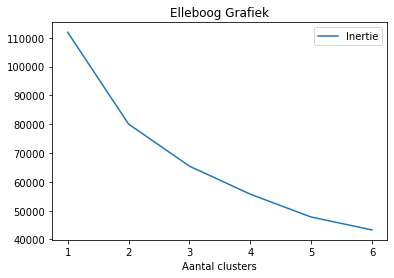

In [490]:
cardio_cluster = cardio_train_norm.copy()
cardio_cluster.drop('id', inplace=True, axis=1)

cluster_options = [1,2,3,4,5,6]
inertia_vs_no_clusters = []
for no_clusters in cluster_options:
    kmeans = KMeans(n_clusters=no_clusters)
    inertia_vs_no_clusters.append(kmeans.fit(cardio_cluster).inertia_)
    
inertia_results = pd.DataFrame({"Aantal clusters": cluster_options, "Inertie":inertia_vs_no_clusters})

inertia_results.plot(x='Aantal clusters', y="Inertie", title='Elleboog Grafiek')

**Deze elbow plot laat zien dat de grootste knik bij 2 clusters zit, om deze reden kies ik dan ook voor 2 clusters.**

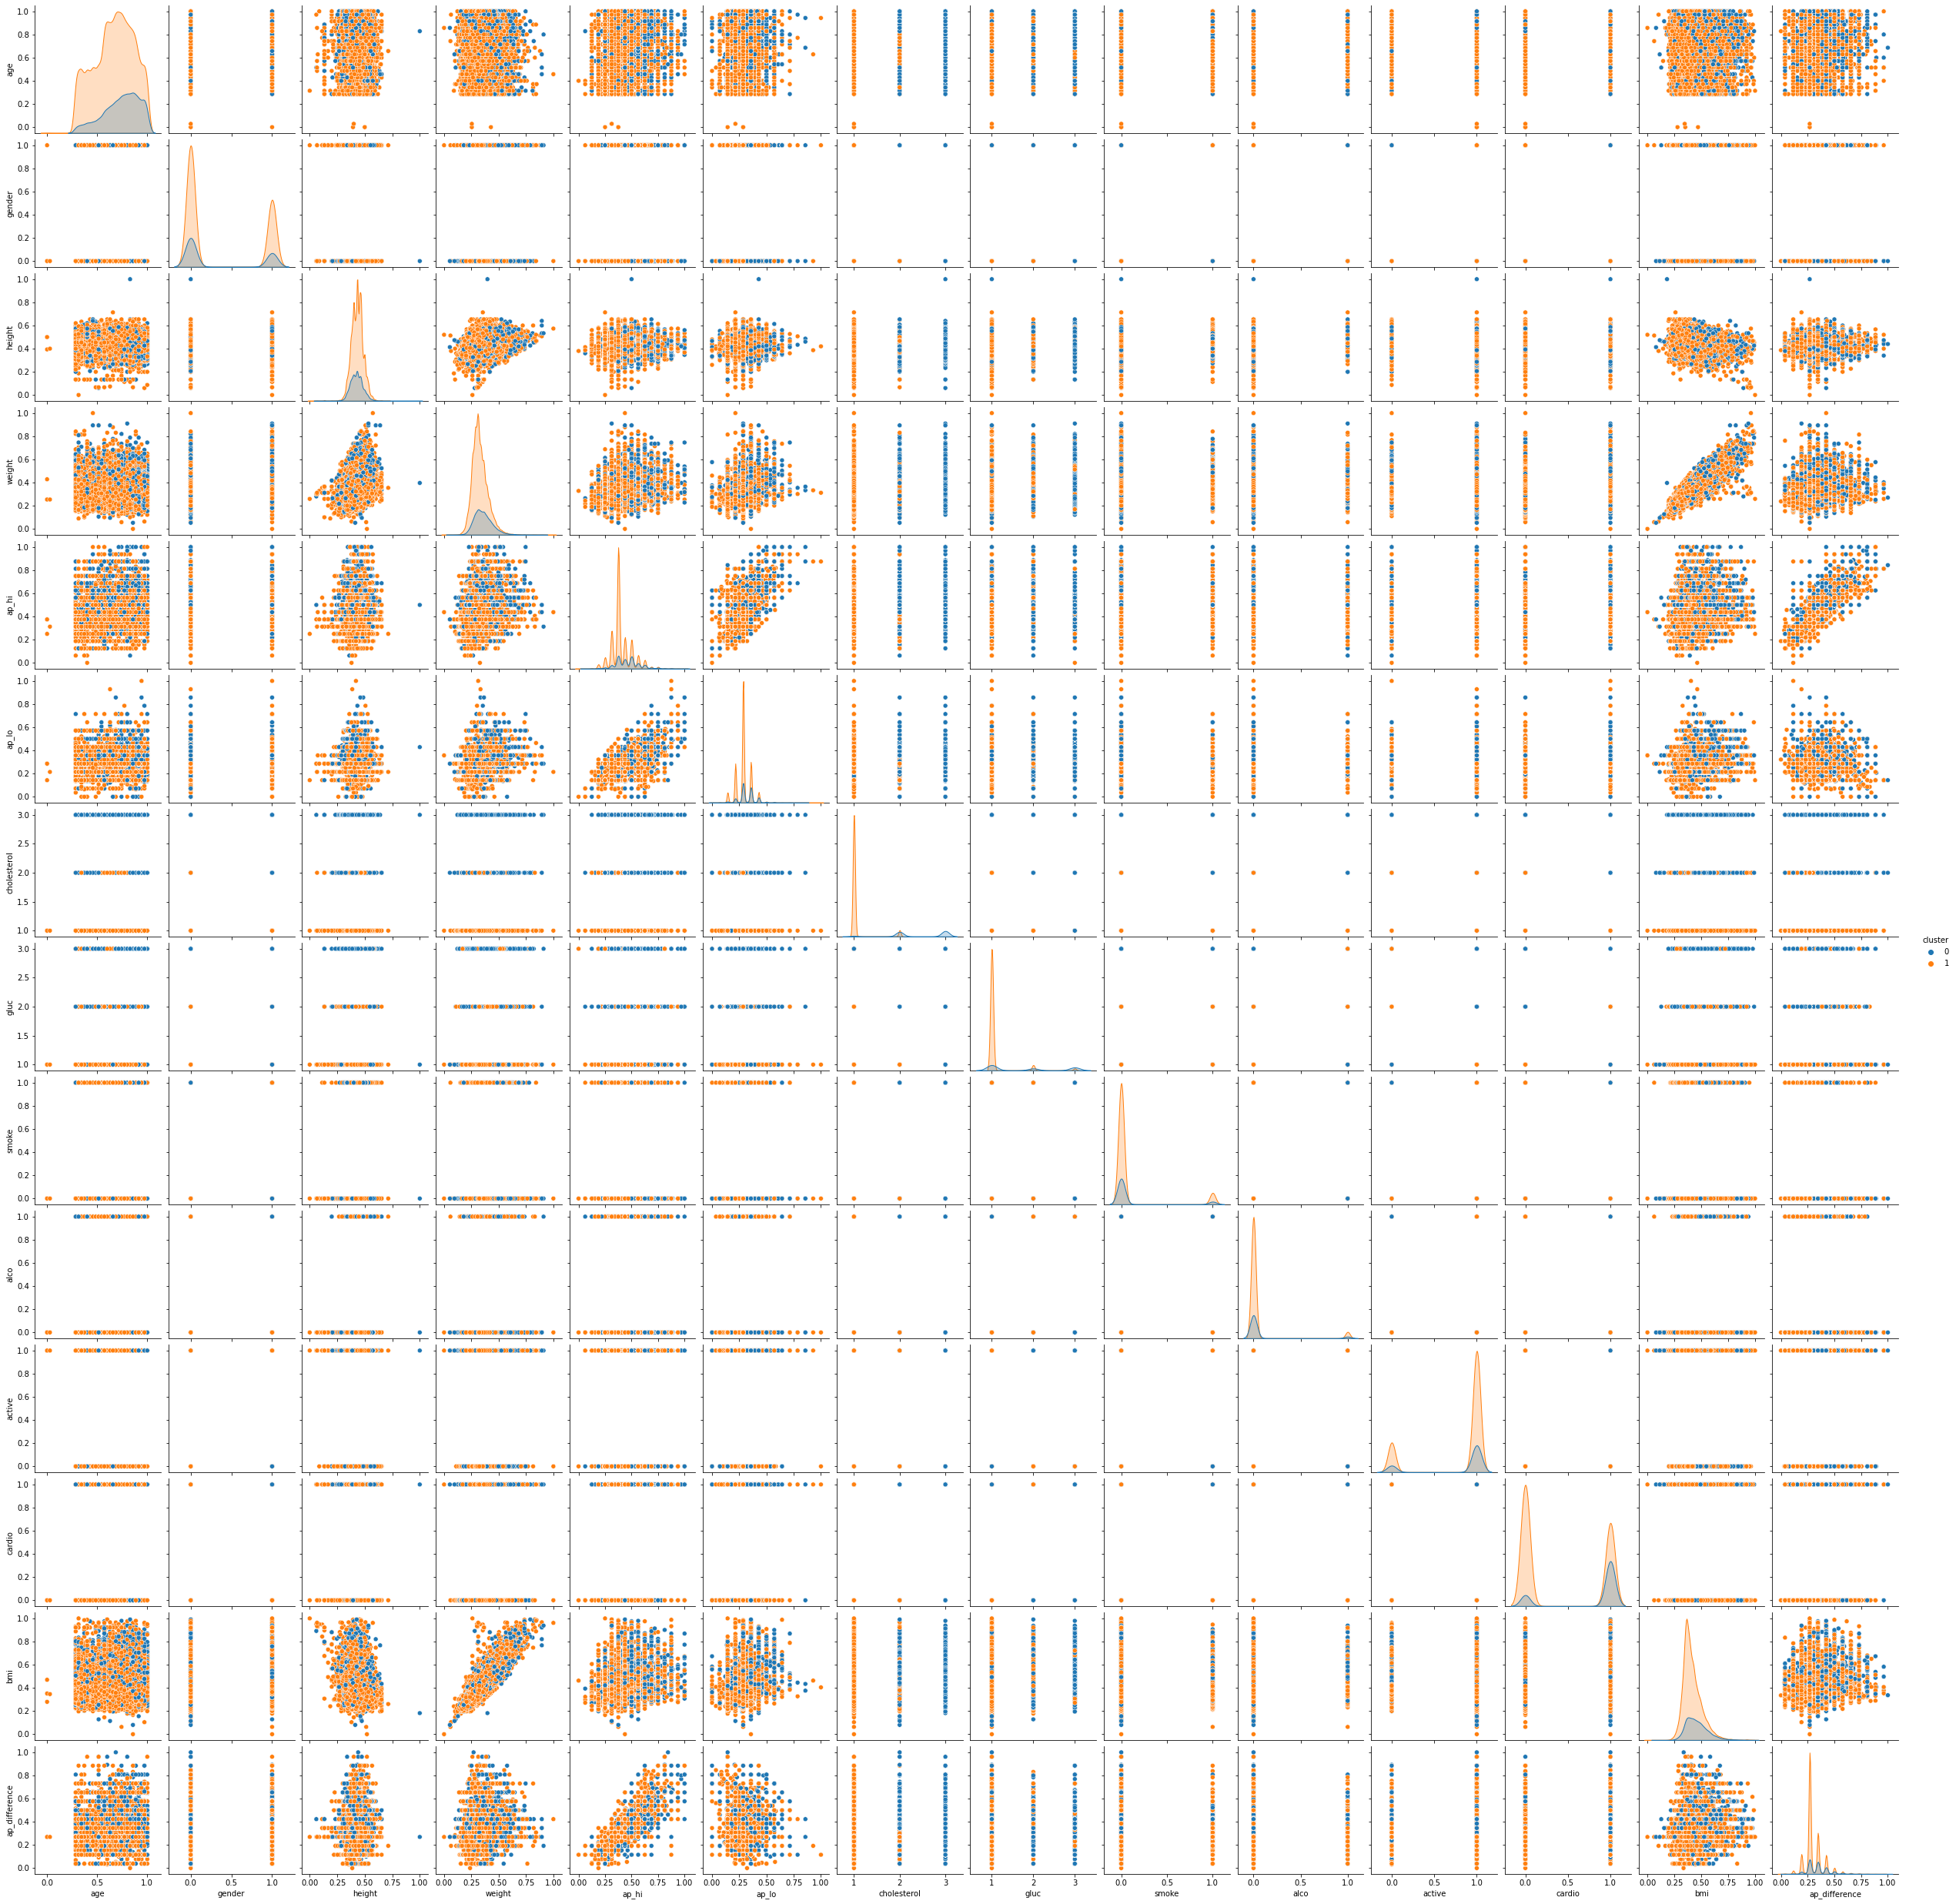

In [491]:
kmeans = KMeans(n_clusters=2)
cardio_kmeans = kmeans.fit(cardio_cluster)
cardio_cluster['cluster'] = cardio_kmeans.labels_
sns.pairplot(cardio_cluster, hue='cluster')

**Uit deze clustering haal ik geen extreme bijzonderheden, want er zitten niet bepaald grote verschillen tussen de clusters.**

In [47]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def EvaluateModel(model, data_train, data_test, label_train, label_test):
    prediction = model.predict(data_test)
    prediction = prediction > 0.5
    conf_mat = confusion_matrix(label_test, prediction)
    falsePositive = conf_mat[1][0]

    print(conf_mat)
    print(str(falsePositive) + " people of the " + str(conf_mat[1].sum()) + " that have a CVD didnt get diagnosed with it")
    print("That is " + str(round(falsePositive/conf_mat.sum()*100,2)) + "% of all patients that died because of no treatment!")
    pred = model.predict(data_train)>0.5
    pred = [bool(x) for x in pred]
    acc_train = round(((pred==label_train).sum())/(len(label_train))*100, 4)
    print("Accuracy van de training data: " + str(acc_train) + "%")
    pred = model.predict(data_test)>0.5
    pred = [bool(x) for x in pred]
    acc_test = round(((pred==label_test).sum())/(len(label_test))*100, 4)
    print("Accuracy van de test data: " + str(acc_test) + "%")
    print("Verschil: " + str(round(acc_test-acc_train,2)) + "%")

### Logistic Regression

In [494]:
model = LogisticRegression()
model.fit(LR_data_train, label_train)
EvaluateModel(model, LR_data_train,LR_data_test, label_train, label_test)

[[8272 2193]
 [3386 6730]]
3386 people of the 10116 that have a CVD didnt get diagnosed with it
That is 16.45% of all patients that died because of no treatment!
Accuracy van de training data: 72.5224%
Accuracy van de test data: 72.8925%
Verschil: 0.37%


E:\Software\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Gradient Boosting Trees

In [56]:
gdc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=2, random_state=42)
gdc.fit(NB_data_train, label_train)
EvaluateModel(gdc, NB_data_train, NB_data_test, label_train, label_test)

[[8056 2409]
 [3048 7068]]
3048 people of the 10116 that have a CVD didnt get diagnosed with it
That is 14.81% of all patients that died because of no treatment!
Accuracy van de training data: 73.8115%
Accuracy van de test data: 73.4853%
Verschil: -0.33%


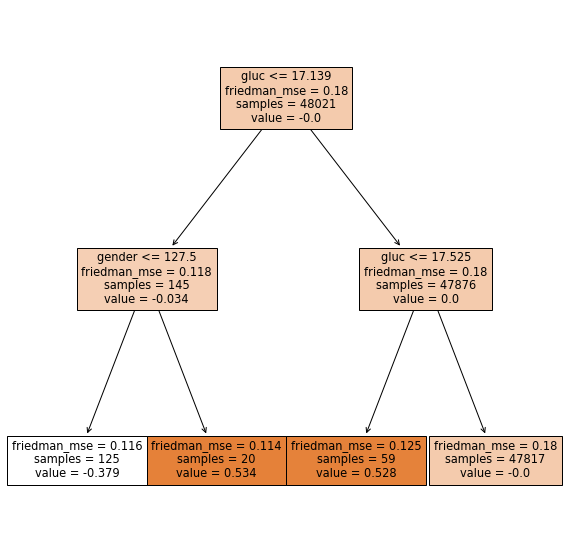

In [57]:
from sklearn import tree

plt.figure(figsize=(10,10))
_ = tree.plot_tree(gdc.estimators_[42, 0], feature_names=data_train.columns, filled=True)
plt.show()

### Linear Support Vector Classification

In [48]:
model = LinearSVC(dual=False)
model.fit(LSVC_data_train, label_train)
EvaluateModel(model, LSVC_data_train, LSVC_data_test,label_train,label_test)

[[8371 2094]
 [3466 6650]]
3466 people of the 10116 that have a CVD didnt get diagnosed with it
That is 16.84% of all patients that died because of no treatment!
Accuracy van de training data: 72.5683%
Accuracy van de test data: 72.9848%
Verschil: 0.42%


### Support Vector Machine

#### Eerste SVM

In [89]:
clf_svm = SVC(random_state=42)
clf_svm.fit(SVM_data_train, label_train)

SVC(random_state=42)

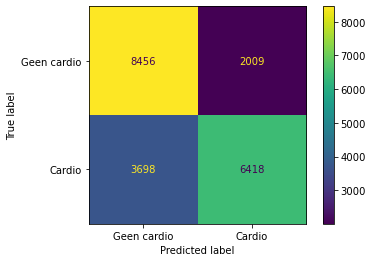

In [90]:
plot_confusion_matrix(clf_svm,
                     SVM_data_test,
                     label_test,
                     values_format='d',
                     display_labels=['Geen cardio', 'Cardio'])

In de confusion matrix zien we dat 72,27% (14874) van de mensen die een cardiovasculaire ziekte goed worden geclassificeerd door dit model. 17.96% (3698) van de mensen met een cardiovasculaire ziekte wordt niet herkend. Dit zou betekenen dat ongever 2 op de 10 mensen volgens dit model onterecht 'geen risico' lopen.

#### Parameters optimalizeren met cross validation

Om een support vector machine te optimaliseren wordt er gefocust op het vinden van de best mogelijke waarde voor gamma en daarnaast de regularization parameter, C.

Omdat we 2 parameters hebben gebruiken we GridSearchCV(). We speciferen een aantal mogelijke combinaties en GridSearchCV() test al deze mogelijkheden.

In [92]:
param_grid = [
    {'C': [0.5, 1, 10, 100], # C moet groter zijn dan 0
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']},
]

# Ik gebruik C=1 en gamme=scale omdat dit default values zijn.

optimal_params = GridSearchCV(
                    SVC(),
                    param_grid,
                    cv=5,
                    scoring='accuracy', #accuracy is default er zijn nog andere mogelijkheden maar deze verbeteren dit model nauwelijks in ons geval.
                    verbose=0) 

optimal_params.fit(SVM_data_train, label_train)
print(optimal_params.best_params_)

KeyboardInterrupt: 

Na cross validation te hebben gedaan zien we dat de ideale value voor C 100 is en voor gamma 0.001

#### Final SVM maken

In [93]:
clf_svm = SVC(random_state=42, C=100, gamma=0.001) 
clf_svm.fit(SVM_data_train, label_train)

SVC(C=100, gamma=0.001, random_state=42)

In [95]:
EvaluateModel(clf_svm, SVM_data_train, SVM_data_test, label_train, label_test)

[[8318 2147]
 [3397 6719]]
3397 people of the 10116 that have a CVD didnt get diagnosed with it
That is 16.51% of all patients that died because of no treatment!
Accuracy van de training data: 73.5678%
Accuracy van de test data: 73.0625%
Verschil: -0.51%


Het optimaliseren heeft in ons geval niet veel geholpen. Het model kan erg goed mensen die geen cardiovasculaire ziekte hebben goed classificeren (85%), maar dit is niet onze target. Wij willen juist een model dat zo min mogelijk mensen met cardiovasculaire ziekte classificeerd als 'geen cardio'.

Als je de parameters iets tweaked kun je wel op een lager percentage komen linksonder, maar dat gaat wel ten koste van de mensen zonder cardio die correct worden geclassificeerd. Dit moeten we overleggen met onze opdrachtgever.

### Naive Bayes Model

In [187]:
model = GaussianNB()
model.fit(NB_data_train, label_train)
EvaluateModel(model, NB_data_train, NB_data_test, label_train, label_test)
y_pred = model.predict(NB_data_test)


[[8710 1755]
 [3981 6135]]
3981 people of the 10116 that have a CVD didnt get diagnosed with it
That is 19.34% of all patients that died because of no treatment!
Accuracy van de training data: 72.1393%
Accuracy van de test data: 72.1296%
Verschil: -0.01%


### RandomForestClassifier

In [188]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth = 6, criterion='entropy', random_state=42)
model.fit(normalized_train, label_train)
EvaluateModel(model, normalized_train, normalized_test, label_train, label_test)

[[8415 2050]
 [3472 6644]]
3472 people of the 10116 that have a CVD didnt get diagnosed with it
That is 16.87% of all patients that died because of no treatment!
Accuracy van de training data: 73.0993%
Accuracy van de test data: 73.1694%
Verschil: 0.07%


### DecisionTreeClassifier

In [189]:
model = DecisionTreeClassifier(max_depth=7, random_state=42)
model.fit(DTC_data_train, label_train)
EvaluateModel(model, DTC_data_train, DTC_data_test, label_train, label_test)

[[8260 2205]
 [3314 6802]]
3314 people of the 10116 that have a CVD didnt get diagnosed with it
That is 16.1% of all patients that died because of no treatment!
Accuracy van de training data: 73.6115%
Accuracy van de test data: 73.184%
Verschil: -0.43%


### KNeighbors Classifier

In [190]:
knn = KNeighborsClassifier()
knn.fit(KNC_data_train, label_train)
EvaluateModel(knn, KNC_data_train, KNC_data_test, label_train, label_test)

[[6978 3487]
 [4382 5734]]
4382 people of the 10116 that have a CVD didnt get diagnosed with it
That is 21.29% of all patients that died because of no treatment!
Accuracy van de training data: 74.7631%
Accuracy van de test data: 61.7657%
Verschil: -13.0%


Bij het proberen van veel clusters, is naar voren gekomen dat het niet heel veel uitmaakt voor de accuracy hoeveel cluster je hebt.

### Neural Network

In [263]:
from tensorflow import keras
from tensorflow.keras import layers
len(NN_data_train.columns)

14

In [462]:
# Import the sequential model and dense layer
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.python.keras.optimizer_v2.adam import Adam

# Create a sequential model
def GetModel(saved):
    if (saved):
        modelNN = keras.models.load_model('NNModel_12.6%.h5')
    else:
        modelNN = Sequential()

        # Add a dense layer 
        modelNN.add(Dense(32, input_shape=(11,), activation='relu'))
        modelNN.add(Dense(64, activation='relu'))
        modelNN.add(Dense(128, activation='relu'))
        modelNN.add(Dense(1,activation='sigmoid'))

        # Compile your model
        modelNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],)

        # Display a summary of your model
        modelNN.summary()
    return modelNN

modelNN = GetModel(True)

In [459]:
history = modelNN.fit(NN_data_train, NN_lab_train , epochs=23, validation_data=(NN_val_data_train,NN_val_lab_train))


Epoch 1/23
751/751 [==============================] - 1s 1ms/step - loss: 0.5428 - accuracy: 0.7323 - val_loss: 0.5431 - val_accuracy: 0.7332
Epoch 2/23
751/751 [==============================] - 1s 1ms/step - loss: 0.5433 - accuracy: 0.7322 - val_loss: 0.5434 - val_accuracy: 0.7331
Epoch 3/23
751/751 [==============================] - 1s 1ms/step - loss: 0.5427 - accuracy: 0.7319 - val_loss: 0.5489 - val_accuracy: 0.7295
Epoch 4/23
751/751 [==============================] - 1s 1ms/step - loss: 0.5421 - accuracy: 0.7315 - val_loss: 0.5435 - val_accuracy: 0.7329
Epoch 5/23
751/751 [==============================] - 1s 1ms/step - loss: 0.5408 - accuracy: 0.7329 - val_loss: 0.5484 - val_accuracy: 0.7299
Epoch 6/23
751/751 [==============================] - 1s 1ms/step - loss: 0.5419 - accuracy: 0.7327 - val_loss: 0.5487 - val_accuracy: 0.7288
Epoch 7/23
751/751 [==============================] - 1s 1ms/step - loss: 0.5409 - accuracy: 0.7325 - val_loss: 0.5482 - val_accuracy: 0.7303
Epoch 

In [328]:
NN_val_data_train.duplicated().sum()

493

In [463]:
EvaluateModel(modelNN, NN_normalized_train, NN_normalized_test, label_train, label_test)

[[7569 2896]
 [2593 7523]]
2593 people of the 10116 that have a CVD didnt get diagnosed with it
That is 12.6% of all patients that died because of no treatment!
Accuracy van de training data: 73.0951%
Accuracy van de test data: 73.3298%
Verschil: 0.23%


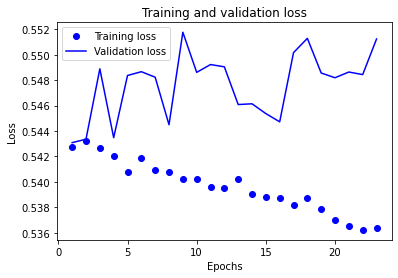

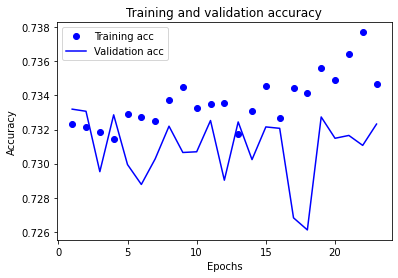

In [465]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.clf()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [53]:
#modelNN.save('NNModel_12.6%.h5')

In [85]:
import keras.models as km
modelNN = keras.model.load_model('NNModel_12.6%.h5')


In [70]:
modelNames = ['Logistic Regression','Gradient Boosting Trees','Linear SVC','SVM'
              ,'Naive Bayes','Random Forest Classifier','Decision Tree Classifier','KNeighbours Classifier','Neural Network']
train = [72.52,73.81,72.57,73.57,72.14,73.10,73.61,74.76,73.10]
test = [72.89,73.49,72.98,73.06,72.13,73.17,73.18,61.77,73.33]

type1 = [16.45,14.81,16.84,16.51,19.34,16.87,16.10,21.29,12.6]
res = {'model':modelNames,'train_accuracy':train, 'test_accuracy':test,'type-1 error':type1}
results = pd.DataFrame(data=res)

In [71]:

results['difference'] = (results['train_accuracy'] - results['test_accuracy']).abs()
results = results.set_index('model')
results.sort_values('type-1 error')

,train_accuracy,test_accuracy,type-1 error,difference
model,,,,
Neural Network,73.10,73.33,12.60,0.23
Gradient Boosting Trees,73.81,73.49,14.81,0.32
Decision Tree Classifier,73.61,73.18,16.10,0.43
Logistic Regression,72.52,72.89,16.45,0.37
SVM,73.57,73.06,16.51,0.51
Linear SVC,72.57,72.98,16.84,0.41
Random Forest Classifier,73.10,73.17,16.87,0.07
Naive Bayes,72.14,72.13,19.34,0.01
KNeighbours Classifier,74.76,61.77,21.29,12.99


# Hoe nu verder?

* Tot nu toe hebben we:</br>
    Business Understanding</br>
    Data Understanding</br>
    Data Preparation</br>
    Modeling van Naive Bayes</br>
    </br>
* Hoe nu verder:</br>
    Modeling van meerdere algoritmes</br>
    Volgende week (hopen we) bezig met echte data </br>